In [1]:
suppressPackageStartupMessages({
  library(cellAdmix)
  library(ggplot2)
  library(ggrepel)
  library(pagoda2)
  library(readr)
  # library(dplyr)
  # library(reshape2)
  # library(data.table)
  # library(sccore)
  # library(NMF)
  # library(ggplot2)
  # library(CRF)
  # library(ggrepel)
  # library(arrow)
  # library(parallel)
  # library(igraph)
  # library(gtools)
  # library(RColorBrewer)
  # library(deldir)
  # library(dataorganizer)
  # library(EBImage)
  # library(pagoda2)
  # library(ggrastr)
  # library(ggnewscale)
  # library(viridis)
  # library(magrittr)
  # library(Matrix)
  # library(ggridges)
  # library(scales)
  # library(readr)
  # library(Seurat)
  # library(sparseMatrixStats)
  # library(cowplot)
  # library(devtools)
  # library(RANN)
  # library(ComplexHeatmap)
  # library(circlize)
})

suppressMessages({
  devtools::load_all()
  load_arial_font()
})

In [2]:
ct_list_df <- load_markers_gut(filter_markers=FALSE)

stemta.marker.genes <- ct_list_df[ct_list_df$marker_of=='Stem + TA','gene']
ent.marker.genes <- ct_list_df[ct_list_df$marker_of=='Enterocyte','gene']
gob.marker.genes <- ct_list_df[ct_list_df$marker_of=='Goblet','gene']

In [3]:
# load counts version of org and clean data
base_dir <- CachePath('gut_scaled_dat6/')
so_spatial_orig <- file.path(base_dir,'so_spatial_orig.rds') %>% readRDS()
so_spatial_cln <- file.path(base_dir,'so_spatial_cln_20_full.rds') %>% readRDS()

dat_orig <- so_spatial_orig[['RNA']]$counts
meta_orig <- so_spatial_orig@meta.data

dat_cln <- so_spatial_cln[['RNA']]$counts
meta_cln <- so_spatial_cln@meta.data

# subset data to same cells and genes
cells_both <- intersect(colnames(dat_orig),colnames(dat_cln))
dat_orig <- dat_orig[,cells_both]
dat_cln <- dat_cln[,cells_both]
meta_orig <- meta_orig[cells_both,]

ndx_change <- which(rownames(dat_orig)=='H2-Eb1')
rownames(dat_orig)[ndx_change] <- 'H2.Eb1'
ndx_change <- which(rownames(dat_cln)=='H2-Eb1')
rownames(dat_cln)[ndx_change] <- 'H2.Eb1'

In [4]:
# append region annotations
gut_regions <- DatasetPath('mouse_gut', 'gut_regions.rds') %>% readRDS()
gut_regions <- gut_regions[rownames(meta_orig)]
meta_orig$niche <- gut_regions
meta_orig$niche <- as.factor(meta_orig$niche)

# label regions for comparison
meta_orig$regions_compare <- sapply(meta_orig$niche,function(x) {
  if (x==3) {
    return('ent_enriched')
  } else if (x==2) {
    return('sta_enriched')
  } else {
    return(NA)
  }
})

In [5]:
# subset to just goblet cells
cells_keep <- rownames(meta_orig)[meta_orig$cell_type=='Goblet']
meta_orig <- meta_orig[cells_keep,]
dat_orig <- dat_orig[,cells_keep]
dat_cln <- dat_cln[,cells_keep]

meta_cln <- meta_orig

In [6]:
## run de for original counts
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,min.transcripts.per.cell = 50,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$regions_compare
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                            upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['sta_enriched']]

272 cells, 241 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

1 overdispersed genes ... 1

persisting ... 

done.

running PCA using 241 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:




running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 233 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_point()`).”


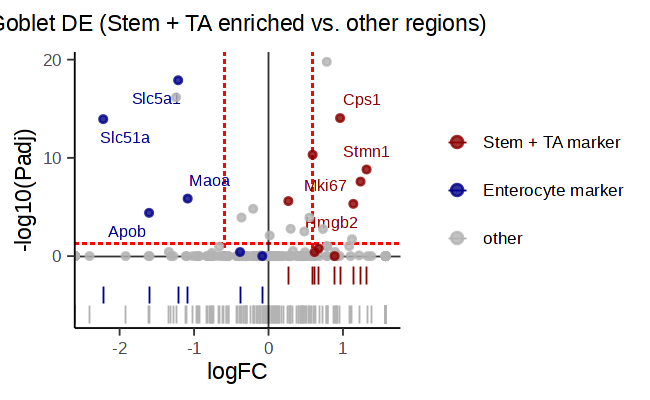

In [7]:
options(repr.plot.width = 3.25, repr.plot.height = 2, repr.plot.res = 200)

## making volcano plot for original DE
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
    if (x %in% stemta.marker.genes) {
      return('Stem + TA marker')
    } else if (x %in% ent.marker.genes) {
      return('Enterocyte marker')
    } else {
      return('other')
    }
})
de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- c('Cps1','Stmn1','Hmgb2','Mki67','Slc5a1','Slc51a','Apob','Maoa')
ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>50] <- 50
ymax <- max(de_out_orig$logpv,na.rm=TRUE) + 1
myColors <- c('red4','blue4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('Stem + TA marker','Enterocyte marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5

p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='Enterocyte marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='Stem + TA marker',],alpha=gg_point_alpha,size=gg_point_size) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Goblet DE (Stem + TA enriched vs. other regions)') +
  scale_colour_manual(breaks = c('Stem + TA marker','Enterocyte marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [8]:
pdf(OutputPath("gut_gob_de.pdf"), useDingbats=FALSE, width=3.25, height=2)
p
dev.off()

Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 233 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_point()`).”


png 
  2

In [9]:
## run de for cleaned data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,min.transcripts.per.cell = 50,
                        n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$regions_compare
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                        upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['sta_enriched']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

247 cells, 241 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

1 overdispersed genes ... 1

persisting ... 

done.

running PCA using 241 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


perplexity is too large, reducing to 82


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 233 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


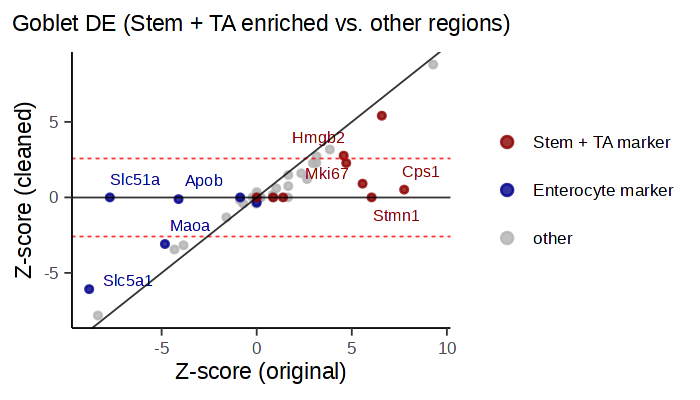

In [10]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
    if (x %in% stemta.marker.genes) {
      return('Stem + TA marker')
    } else if (x %in% ent.marker.genes) {
      return('Enterocyte marker')
    } else {
      return('other')
    }
})
genes_to_label <- c('Cps1','Stmn1','Hmgb2','Mki67','Slc5a1','Slc51a','Apob','Maoa')
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 10
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('Stem + TA marker','other','Enterocyte marker'))
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='Enterocyte marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='Stem + TA marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  ggtitle('Goblet DE (Stem + TA enriched vs. other regions)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(linewidth=gg_line_thickness,yintercept = z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness,yintercept = -1*z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness,yintercept = 0,alpha=gg_line_alpha) +
  geom_abline(linewidth=gg_line_thickness,slope = 1,intercept=0,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('Stem + TA marker','Enterocyte marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [12]:
pdf(OutputPath("gut_de_pre_post.pdf"), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 233 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [ ]:
### now testing for enriched gene sets in both de results
m_df <- data.frame()
m_df <- rbind(m_df,msigdbr::msigdbr(
  species = "Mus musculus", collection = "C5", subcollection = "BP"
))
my_pathways <- split(m_df$gene_symbol, f = m_df$gs_name)

mystats <- abs(de_out_orig$Z)
names(mystats) <- rownames(de_out_orig)
mystats <- mystats[!is.na(mystats)]
mystats <- mystats[is.finite(mystats)]
fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
                               stats = mystats,
                               minSize=10,
                               maxSize=500,
                               eps=0,
                               gseaParam=0,
                               scoreType = "pos")
rownames(fgsea_res_orig) <- fgsea_res_orig$pathway


mystats <- abs(de_out_cln$Z)
names(mystats) <- rownames(de_out_cln)
mystats <- mystats[!is.na(mystats)]
mystats <- mystats[is.finite(mystats)]
fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
                                stats = mystats,
                                minSize=10,
                                maxSize=500,
                                eps=0,
                                gseaParam=0,
                                scoreType = "pos")
rownames(fgsea_res_clean) <- fgsea_res_clean$pathway

Warning message:
“The `category` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `collection` argument instead.”
Warning message:
“The `subcategory` argument of `msigdbr()` is deprecated as of msigdbr 10.0.0.
ℹ Please use the `subcollection` argument instead.”


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message:
“Removed 379 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


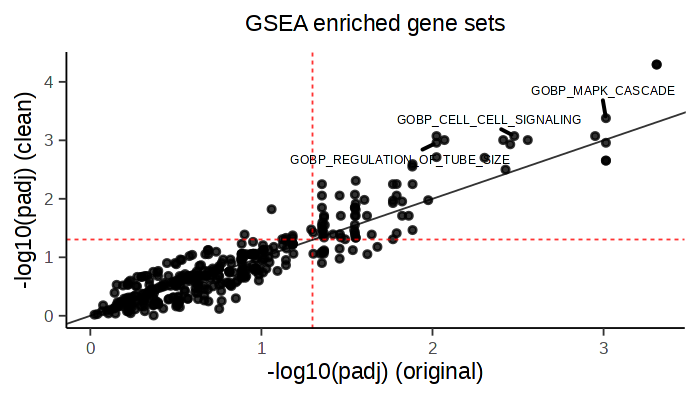

In [14]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

## plot GSEA comparison
fgsea_res_clean <- as.data.frame(fgsea_res_clean)
fgsea_res_orig <- as.data.frame(fgsea_res_orig)
rownames(fgsea_res_clean) <- fgsea_res_clean$pathway
rownames(fgsea_res_orig) <- fgsea_res_orig$pathway
path_both <- intersect(fgsea_res_clean$pathway,fgsea_res_orig$pathway)
tmp <- cbind.data.frame(-log10(fgsea_res_clean[path_both,'padj']),-log10(fgsea_res_orig[path_both,'padj']))
colnames(tmp) <- c('clean','orig')
rownames(tmp) <- path_both
tmp$gslab <- NA
ndx_lab <- which(rownames(tmp) %in% c('GOBP_CELL_CELL_SIGNALING',
                                   'GOBP_MAPK_CASCADE',
                                   'GOBP_REGULATION_OF_TUBE_SIZE'))
tmp$gslab[ndx_lab] <- fgsea_res_clean$pathway[ndx_lab]
p <- ggplot(tmp,aes(x=orig,y=clean,label=gslab)) +
  geom_point(alpha=gg_point_alpha,size=gg_point_size) +
  geom_text_repel(size=(3*geom_text_size)/4,show.legend = FALSE,family=font_choice,min.segment.length = 0) +
  geom_vline(xintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  xlab('-log10(padj) (original)') +
  ylab('-log10(padj) (clean)') +
  ggtitle('GSEA enriched gene sets') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [15]:
pdf(OutputPath("gut_gsea_compare.pdf"), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 379 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2